# Closing Roads

## Helper Functions for Loading the Data

In [2]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from datetime import datetime
from dateutil import parser
from sklearn import preprocessing
# pip install azureml-opendatasets-runtimeusing
from azureml.opendatasets import NycTlcYellow
import calendar
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import pickle
import momepy
import itertools
# torch stuff
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from tqdm import tqdm
import copy
import os.path
from sklearn.metrics import classification_report
from sklearn.utils.extmath import softmax
from pprint import pprint
from itertools import islice

# Only need to run this function once
def preprocess_lion():
    # Download data from https://www.dropbox.com/sh/927yoof5wq6ukeo/AAA--Iyb7UUDhfWIF2fncppba?dl=0
    # Put all files into 'data_unwrangled/LION' or change path below
    lion_folder = 'data_unwrangled/LION/'
    # Load all LION data
    links = gpd.read_file(lion_folder+'links.shp')
    # Only consider links in Manhattan
    links = links[links['LBoro']==1]
    # Only consider links that are normal streets
    links = links[links['FeatureTyp']=='0']
    # Only consider constructed links
    links = links[links['Status']=='2']
    # Only consider links that have vehicular traffic
    links = links[links['TrafDir'] != 'P']
    # Make sure there is a speed limit for each link
    links = links[links['POSTED_SPE'].notnull()]
    # Expected time to travel link at posted speed
    links['expected_time'] = links['POSTED_SPE'].astype(int)*links['SHAPE_Leng']
    # Ensure *undirected* graph is connected
    # Note: We could do this for directed graph but maximum size
    # of strongly connected component is 430
    graph = momepy.gdf_to_nx(links, approach="primal", directed=False)
    for component in nx.connected_components(graph):
        if len(component) > 10000:
            graph = graph.subgraph(component)
    # Use resulting links as infrastructure
    _, links = momepy.nx_to_gdf(graph)
    links.drop(columns=['node_start', 'node_end'], inplace=True)
    # Save both links so we can use it to construct directed graph
    links.to_file('data/links.json', driver='GeoJSON')
    # Load nodes
    nodes = gpd.read_file(lion_folder+'nodes.shp')
    # Drop unnecessary columns
    nodes.drop(columns=['OBJECTID_1', 'OBJECTID', 'GLOBALID', 'VIntersect'], inplace=True)
    # Find nodes that are connected to surviving links
    node_IDs = np.union1d(links['NodeIDFrom'], links['NodeIDTo']).astype(int)
    # Select nodes that are connected to surviving links
    selected_nodes = nodes[nodes['NODEID'].isin(node_IDs)]
    # Save to file
    selected_nodes.to_file('data/nodes.json', driver='GeoJSON')

# Only need to run this function once
# Rerun if we change the links data!
def preprocess_dual_graph():
    links = gpd.read_file('data/links.json')
    # Get outgoing edges from each node
    outgoing_edges = {}
    total = 0
    for objectid, from_node, to_node, trafdir in zip(links['OBJECTID'], links['NodeIDFrom'], links['NodeIDTo'], links['TrafDir']):
        if trafdir == 'W' or trafdir == 'T':
            if to_node not in outgoing_edges:
                outgoing_edges[to_node] = []
            outgoing_edges[to_node] += [objectid]
        if trafdir == 'A' or trafdir == 'T':
            if from_node not in outgoing_edges:
                outgoing_edges[from_node] = []
            outgoing_edges[from_node] += [objectid]
    # Build graph
    graph = nx.DiGraph()
    for objectid, from_node, to_node, trafdir in zip(links['OBJECTID'], links['NodeIDFrom'], links['NodeIDTo'], links['TrafDir']):
        graph.add_node(objectid)
        if trafdir == 'W' or trafdir == 'T':
            for outgoing_objectid in outgoing_edges[to_node]:
                graph.add_node(outgoing_objectid)
                graph.add_edge(objectid, outgoing_objectid)
        if trafdir == 'A' or trafdir == 'T':
            for outgoing_objectid in outgoing_edges[from_node]:
                graph.add_node(outgoing_objectid)
                graph.add_edge(objectid, outgoing_objectid)
    # Make sure we have correct number of nodes
    assert len(graph.nodes) == len(links['OBJECTID'].unique())
    pickle.dump(graph, open('data/dual_graph.pkl', 'wb'))
    return graph

def load_filter():
    filename_filter = 'data_unwrangled/2010 Neighborhood Tabulation Areas (NTAs).geojson'
    filter = gpd.read_file(filename_filter)
    filter = filter[filter['boro_name'] == 'Manhattan']
    return filter

def connect_collisions_to_links(collisions):
    links = gpd.read_file('data/links.json')
    links = links[['OBJECTID', 'geometry']]
    collisions.to_crs(links.crs, inplace=True)
    return collisions.sjoin_nearest(links).drop(columns=['index_right'])

# Only need to run this function once for each year
def preprocess_collisions(year=2013):
    filename_collisions = 'data_unwrangled/Motor_Vehicle_Collisions_-_Crashes.csv'
    # Load collisions and drop empty rows
    df = pd.read_csv(filename_collisions, low_memory=False).dropna(subset=['LATITUDE', 'LONGITUDE', 'CRASH DATE'])
    # Drop empty location data
    df = df[df.LONGITUDE != 0] # remove 0,0 coordinates
    # Convert date to datetime
    df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
    # Get year
    df['year'] = df['CRASH DATE'].dt.year
    # Convert to geodataframe
    gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE))
    # Filter to Manhattan
    gdf = gdf.sjoin(load_filter()).drop(columns=['index_right'])
    # Subset to year
    gdf_year = gdf[gdf['year']==year]    
    # Connect collisions to nodes
    gdf_year = connect_collisions_to_links(gdf_year)
    # Save to file
    gdf_year.to_file(f'data/collisions_{year}.json', driver='GeoJSON')

def preprocess_taxi(df):
    # Make sure rides are longer than one minute
    df = df[df['tpepDropoffDateTime'] - df['tpepPickupDateTime'] > np.timedelta64(1, 'm')]
    # Make sure rides are shorter than 12 hours
    df = df[df['tpepDropoffDateTime'] - df['tpepPickupDateTime'] <= np.timedelta64(12, 'h')]
    # Make sure rides are longer than .1 mile
    df = df[df['tripDistance'] > 0.1]
    # Make sure fare is non-zero 
    df = df[df['fareAmount'] > 0.0]
    # Convert to geopandas
    gdf = gpd.GeoDataFrame(df)
    # Reset index ID (there are duplicate indices)
    gdf.reset_index(inplace=True)
    # Create ride ID
    gdf['ride_id'] = gdf.index
    # Make start time date time type
    gdf['start_time'] = pd.to_datetime(gdf['tpepPickupDateTime'])
    # Round start time to day
    gdf['start_day'] = gdf['start_time'].dt.round('d')
    return gdf

def filter_location(type, filter, taxi, make_copy=True):
    # Create a geometry column from the type coordinates
    taxi[f'{type}_geom'] = gpd.points_from_xy(taxi[f'{type}Lon'], taxi[f'{type}Lat'])
    taxi.set_geometry(f'{type}_geom', crs='epsg:4326', inplace=True)
    taxi = taxi.sjoin(filter).drop(columns=['index_right'])
    return taxi

def restrict_start_end(taxi, check_ratio=False):        
    # Load Manhattan objects
    filter_manhattan = load_filter()
    # Restrict to rides that start in Manhattan
    taxi_start = filter_location('start', filter_manhattan, taxi)
    # Restrict to rides that start and end in Manhattan
    taxi_start_end = filter_location('end', filter_manhattan, taxi_start)
    if check_ratio:
        # Check number of rides that start AND end in Manhattan / number of rides that start OR end in Manhattan
        taxi_end = filter_location('end', filter_manhattan, taxi)
        print(len(taxi_start_end)/(len(taxi_start)+len(taxi_end)-len(taxi_start_end))) # About 85%
    return taxi_start_end

def get_taxi_data(year, month):
    # Get query for first and last day of month in year
    month_last_day = calendar.monthrange(year=int(year),month=int(month))[1]
    start_date = parser.parse(str(year)+'-'+str(month)+'-01')
    end_date = parser.parse(str(year)+'-'+str(month)+'-'+str(month_last_day))
    #end_date = parser.parse(str(year)+'-'+str(month)+'-02')
    print('Loading taxi data...', end=' ')
    nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
    taxi_all = nyc_tlc.to_pandas_dataframe()
    print('complete!')
    print('Preprocessing data...', end=' ')
    taxi = preprocess_taxi(taxi_all)
    print('complete!')
    print('Restricting start and end...', end=' ')
    taxi_start_end = restrict_start_end(taxi)
    print('complete!')

    return taxi_start_end

def get_directed_graph(links):
    # Edges from NodeIDFrom to NodeIDTo for one-way "with" streets and two-way streets
    graph1 = nx.from_pandas_edgelist(
        links[np.logical_or(links['TrafDir'] == 'W', links['TrafDir'] == 'T')],
        source='NodeIDFrom', target='NodeIDTo', edge_attr=True, create_using=nx.DiGraph()
    )
    # Edges from NodeIDTo to NodeIDFrom for one-way "against" streets and two-way streets
    graph2 = nx.from_pandas_edgelist(
        links[np.logical_or(links['TrafDir'] == 'A', links['TrafDir'] == 'T')],
        source='NodeIDTo', target='NodeIDFrom', edge_attr=True, create_using=nx.DiGraph()
    )
    return nx.compose(graph1, graph2)

def connect_taxi_to_nodes(taxi, type_name, nodes):    
    taxi.set_geometry(type_name+'_geom', inplace=True)
    taxi.to_crs(nodes.crs, inplace=True)
    result = taxi.sjoin_nearest(nodes).drop(columns=['index_right'])
    result.rename(columns={'NODEID': type_name+'_NODEID'}, inplace=True)
    return result

# About 8 minutes for one million trips
def get_flows(taxi, graph, links):
    # Initialize dictionary for fast access
    flow_day = {'increasing_order': {}, 'decreasing_order': {}}
    for objectid, trafdir in zip(links['OBJECTID'], links['TrafDir']):
        flow_day['increasing_order'][objectid] = 0
        flow_day['decreasing_order'][objectid] = 0
    flows = {np.datetime_as_string(day, unit='D') : dict(flow_day) for day in taxi['start_day'].unique()}
    # Sort by start node so we can re-use predecessor graph
    taxi_sorted = taxi.sort_values(by=['start_NODEID', 'end_NODEID'])
    previous_source = None
    for source, target, day in zip(taxi_sorted['start_NODEID'], taxi_sorted['end_NODEID'], taxi_sorted['start_day']):
        # Networkx pads node ID with leading zeroes
        source_padded = str(source).zfill(7)
        target_padded = str(target).zfill(7)
        day_pretty = np.datetime_as_string(np.datetime64(day), unit='D')
        # If we haven't already computed the predecessor graph
        if previous_source != source_padded:
            # Compute predecessor graph
            pred, dist = nx.dijkstra_predecessor_and_distance(graph, source=source_padded, weight='expected_time') 
        # We ignore taxi rides that appear infeasible in the directed graph
        if target_padded not in pred:
            continue
        # Follow predecessors to get path
        current, previous = target_padded, None
        while current != source_padded:
            current, previous = pred[current][0], current
            edge_id = (current, previous)
            objectid = graph.edges[edge_id]['OBJECTID']
            if current < previous: # string comparison
                flows[day_pretty]['increasing_order'][objectid] += 1
            else:
                flows[day_pretty]['decreasing_order'][objectid] += 1
        previous_source = source_padded
    return flows

# NOTE: Turns out, the WT-- columns signify whether an extreme 
# weather took place or not. If not, they get a NaN value. So NaNs
# should be replaced with 0. Other NaNs are sparse, so we can fill forward.
def preprocess_weather(years=[2013]):
    # Convert to int because that's how it's stored in the dataframe
    years = [int(year) for year in years]
    df = pd.read_csv('data/weather.csv')
    df['date'] = pd.to_datetime(df.DATE)
    df['year'] = df.date.dt.year
    # Restrict to years we want
    df = df[df.year.isin(years)]
    # If we want more, we can one hot encode the NAN values
    severe_weather_columns = [col for col in df if col.startswith('WT')]
    df[severe_weather_columns] = df[severe_weather_columns].fillna(0.0)
    # For columns missing only a few values, fill forward seems reasonable
    fill_forward_columns = ['AWND','WDF2','WDF5','WSF2','WSF5']
    df[fill_forward_columns] = df[fill_forward_columns].fillna(method='ffill')
    df = df[df.columns[df.isna().sum() == 0]]

    # Normalize weather data
    df_num = df.select_dtypes(include='number')
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df_num)
    df_normalized = pd.DataFrame(np_scaled, columns = df_num.columns)
    df[df_normalized.columns] = df_normalized

    return df


def prepare_links(links):    
    # Remove columns with missing values
    links_modified = links[links.columns[links.isna().sum() == 0]]

    # Remove columns with unnecessary values
    links_drop_columns = ['Street', 'FeatureTyp', 'FaceCode', 'SeqNum', 'StreetCode', 'LGC1', 'BOE_LGC', 'SegmentID', 'LBoro', 'RBoro', 'L_CD', 'R_CD', 'LATOMICPOL', 'RATOMICPOL', 'LCT2020', 'RCT2020', 'LCB2020', 'RCB2020', 'LCT2010', 'RCT2010', 'LCB2010', 'RCB2010', 'LCT2000', 'RCT2000', 'LCB2000', 'RCB2000', 'LCT1990', 'RCT1990', 'LAssmDist', 'LElectDist', 'RAssmDist', 'RElectDist', 'MapFrom', 'MapTo', 'XFrom', 'YFrom', 'XTo', 'YTo', 'ArcCenterX', 'ArcCenterY', 'NodeIDFrom', 'NodeIDTo', 'PhysicalID', 'GenericID', 'LegacyID', 'FromLeft', 'ToLeft', 'FromRight', 'ToRight', 'Join_ID', 'mm_len', 'geometry']
    links_modified = links_modified.drop(columns=links_drop_columns)

    # Add back columns with missing values that are useful
    links_add_columns = ['NonPed', 'BikeLane', 'Snow_Prior', 'Number_Tra', 'Number_Par', 'Number_Tot']
    for column_name in links_add_columns:
        links_modified[column_name] = links[column_name]

    # Convert categorical columns to one hot encoding
    links_categorical_columns = ['SegmentTyp', 'RB_Layer', 'TrafDir', 'NodeLevelF', 'NodeLevelT', 'RW_TYPE', 'Status'] + links_add_columns
    for column_name in links_categorical_columns:
        links_modified = pd.concat([links_modified, pd.get_dummies(links_modified[column_name], prefix=column_name, dummy_na=True)], axis=1)
        links_modified = links_modified.drop(columns=[column_name])
        
    return links_modified.astype(int)

def get_X_day(data_constant, weather, flows_day, day):
    # Make a deep copy of the constant link data
    data = data_constant.copy(deep=True)
    # Add weather data
    weather_day = weather.loc[weather['DATE'] == day].drop(columns=['STATION', 'NAME', 'DATE', 'date', 'year'])
    # Weather is the same for every link (only one weather station)
    for column_name in weather_day: data[column_name] = weather_day[column_name].values[0]
    # Get flow data on day
    flow_day = pd.DataFrame.from_dict(flows_day)
    # Make sure the index is the same as the link data
    flow_day['OBJECTID'] = flow_day.index
    # Make both indices the same
    flow_day.set_index('OBJECTID', inplace=True)
    data.set_index('OBJECTID', inplace=True)
    # Merge the flow data into the link data
    data = data.merge(flow_day, on='OBJECTID')
    # Make sure the index is sorted so it connects to labels
    data.sort_index(inplace=True)
    return data


def get_X(data_constant, weather, flows):
    X = []
    for day in flows.keys():
        data = get_X_day(data_constant, weather, flows[day], day)
        X += [data.values]
        
    return torch.tensor(np.array(X))

def get_y_day(collisions, links, day):
    label = {objectid : 0 for objectid in links.OBJECTID}
    for crash_day, objectid in zip(collisions['CRASH DATE'], collisions['OBJECTID']):
        crash_day_pretty = np.datetime_as_string(np.datetime64(crash_day), unit='D')
        if day == crash_day_pretty: label[objectid] = 1
    label = pd.DataFrame.from_dict(label, orient='index', columns=['crashes'])
    label.sort_index(inplace=True)
    return label

def get_y(collisions, links, flows):
    y = []
    for day in flows.keys():
        label = get_y_day(collisions, links, day)
        y += [label.values]
    return torch.tensor(np.array(y))

class TrafficDataset(Dataset):
    def __init__(self, years=['2013'], months=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']):
        # Should take under a minute to load
        self.links = gpd.read_file('data/links.json')        
        self.nodes = gpd.read_file('data/nodes.json')        
        self.graph = get_directed_graph(self.links)
        self.collisions = gpd.read_file('data/collisions_2013.json')
        # If we change years, different weather features will be returned
        # because we eliminate columns with missing values
        self.weather = preprocess_weather(years)
        self.year_months = [(year, month) for year in years for month in months]
        self.data_constant = prepare_links(self.links)
        dual_graph = pickle.load(open('data/dual_graph.pkl', 'rb'))
        # Relabel so we can plug into GCN
        assert 0 not in dual_graph.nodes # check we're not already relabeled
        mapping = dict(zip(sorted(self.links['OBJECTID']), range(len(self.links))))
        nx.relabel_nodes(dual_graph, mapping, copy=False)
        assert 0 in dual_graph.nodes # check the relabeling worked
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.edges = torch.tensor(np.array(list(dual_graph.edges))).long().to(self.device).T
    
    def __len__(self):
        return len(self.year_months)
    
    def __getitem__(self, idx):
        year, month = self.year_months[idx]

        filename_flows = f'flows/flow_{year}_{month}.pickle'
        if os.path.isfile(filename_flows):
            flows = pickle.load(open(filename_flows, 'rb'))
        else:
            # If you're getting throttled, reset router IP address and computer IP address
            taxi = get_taxi_data(year, month)
            # Limit number of trips per month
            taxi = connect_taxi_to_nodes(taxi, 'start', self.nodes)
            taxi = connect_taxi_to_nodes(taxi, 'end', self.nodes)
            # Takes 8 minutes to run on 1 million trips
            print('Calculating flows...', end=' ')
            flows = get_flows(taxi, self.graph, self.links)
            print('complete!')
            pickle.dump(flows, open(filename_flows, 'wb'))

        filename_X = f'loaded_data/{year}_{month}_X.pkl'
        filename_y = f'loaded_data/{year}_{month}_y.pkl'
        # NOTE: Make sure you have a ``loaded_data/'' directory
        if os.path.isfile(filename_X):
            X = pickle.load(open(filename_X, 'rb'))
            y = pickle.load(open(filename_y, 'rb'))
        else:
            X = get_X(self.data_constant, self.weather, flows).float()
            y = get_y(self.collisions, self.links, flows)

            pickle.dump(X, open(filename_X, 'wb'))
            pickle.dump(y, open(filename_y, 'wb'))
            
        return X.to(self.device), y.to(self.device), self.edges

## Recurrent Graph Convolutional Neural Network

In [3]:
from torch_geometric_temporal.nn.recurrent import GConvGRU

# adapted from https://gist.github.com/sparticlesteve/62854712aed7a7e46b70efaec0c64e4f
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, output_dim=2, 
                 hidden_dim=32, num_layers = 5, neighborhood_size=3
                ):
        super(RecurrentGCN, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList([GConvGRU(node_features, hidden_dim, neighborhood_size)])
        for _ in range(num_layers - 1):
            self.layers.append(GConvGRU(hidden_dim, hidden_dim, neighborhood_size))
        self.linear = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, graphs, edge_index):
        hidden_states = [None] * len(self.layers)
        predictions = []
        for node_features in graphs:
            hidden_states[0] =  self.layers[0](node_features, edge_index, H=hidden_states[0])
            for i in range(1, len(self.layers)):
                hidden_states[i] = F.relu(self.layers[i](hidden_states[i-1], edge_index, H=hidden_states[i]))
            predictions += [F.dropout(hidden_states[-1])]
        predictions = torch.stack(predictions)
        return self.linear(predictions)

## Loading Data and Initializing the Model

Load the training and validation data. Eventually add more years (maybe up to 2016).

In [20]:
train_dataset = TrafficDataset(months=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'])
valid_dataset = TrafficDataset(months=['12'])
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

Initialize the model, optimizer, and loss function.

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 2
num_updates = 11*num_epochs
warmup_steps = 2

# I hid some hyper parameters in the model's initialization step.
model = RecurrentGCN(node_features = 127).to(device) # Recurrent GCN so we pass temporal information

num_param = sum([p.numel() for p in model.parameters()])
print(f'There are {num_param} parameters in the model.')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = num_epochs)
def warmup(current_step):
    if current_step < warmup_steps:
        return float(current_step / warmup_steps)
    else:                                 
        return max(0.0, float(num_updates - current_step) / float(max(1, num_updates - warmup_steps)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup)
# we reweight by the expected number of collisions / non-collisions
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([150, 19000]))


There are 120546 parameters in the model.


## Training to Predict Collisions

This is a helper function to check the recall/precision of the model.

In [21]:
def verbose_output(out, y):
    if len(out.shape) == 3:
        pred_labels = out.argmax(axis=2).flatten().detach().numpy()
    elif len(out.shape) == 2:
        pred_labels = out.argmax(axis=1).flatten().detach().numpy()
    true_labels = y.flatten().detach().numpy()
    print(f'The model predicted {pred_labels.sum()} collisions.')
    print(f'There were really {y.sum()} collisions.')
    print(classification_report(true_labels, pred_labels))

This is the main training code. For the recurrent graph neural network, it seems to stabilize at .6 recall for positive and negative classes after an epoch or so. Each epoch takes about 5 minutes to run on my computer because there are lots of parameters and I somewhat inefficiently implemented the hidden state update.

In [31]:
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train() # turn on dropout
    for i, (X, y, edges) in enumerate(train_dataloader):
        X, y, edges = X.squeeze(), y.squeeze(), edges.squeeze()
        optimizer.zero_grad()
        out = model(X, edges)
        loss = criterion(out.permute(0,2,1), y)
        loss.backward()
        optimizer.step()
        train_losses += [loss.item()]
        print(f'Epoch: {epoch} \t Iteration: {i} \t Train Loss: {train_losses[-1]}')
        verbose_output(out, y)
        scheduler.step()
    model.eval() # turn off dropout
    for X, y, edges in valid_dataloader:
        X, y, edges = X.squeeze(), y.squeeze(), edges.squeeze()        
        with torch.no_grad():
            out = model(X, edges)
            loss = criterion(out.permute(0,2,1), y)
            valid_losses += [loss.item()]            
        print(f'Epoch: {epoch} \t Valid Loss: {valid_losses[-1]}')
        verbose_output(out, y)

torch.save(model.state_dict(), 'saved_models/RecurrentGCN.pt')

Epoch: 0 	 Iteration: 0 	 Train Loss: 0.7096191644668579
The model predicted 321711 collisions.
There were really 3744 collisions.
              precision    recall  f1-score   support

           0       0.99      0.41      0.58    539204
           1       0.01      0.56      0.01      3744

    accuracy                           0.41    542948
   macro avg       0.50      0.48      0.30    542948
weighted avg       0.99      0.41      0.57    542948

Epoch: 0 	 Iteration: 1 	 Train Loss: 0.7096277475357056
The model predicted 341243 collisions.
There were really 4600 collisions.
              precision    recall  f1-score   support

           0       0.99      0.41      0.58    577130
           1       0.01      0.55      0.01      4600

    accuracy                           0.41    581730
   macro avg       0.50      0.48      0.30    581730
weighted avg       0.98      0.41      0.58    581730

Epoch: 0 	 Iteration: 2 	 Train Loss: 0.6849702000617981
The model predicted 386674 

## Reinforcement Learning

This is the main coding part we have left to do.

The state space consists of a graph and node features including flow, infrastructure, and weather.

The action space is the set of nodes in the graph. Taking an action is equivalent to removing the node from the graph. We can only remove links (nodes) which have another path between their endpoints. How do we enforce this? When we remove a node, we need to implement the following:

* Remove the node from the graph structure

* Reroute the flow around the removed node (remember the node is really a link in the road network)

* Accordingly update the node features for the next state

The reward of taking an action is the difference between the loss of the current state and the resulting state. The loss of a state is the sum over links of the flow divided by the capacity plus the sum over links of the collision risk from our trained collision prediction model. We will also need to implement a way of getting these values from the resulting state.

We will be training a policy using Q-learning. In Q-learning, our goal is to build a model which tells us the expected return of an action in a state if we follow our current policy. Notice this is not *just* the current value of the resulting state but also the future value of all following states.

In particular, we will train a neural network which takes in a graph and node features (the state) and outputs values for each node. The value of each node $a$ should be the Q value $Q(s,a)$ where the state is the graph and node features and $a$ corresponds to removing the node from the graph.

## More to do!

Compare the prediction model to baselines

Compare the q learning model to a greedy baseline which searches for most reward, and a random baseline

## Environment Helper Functions

In [4]:
class Static:
    # Things we only need to load once
    years = ['2013', '2014', '2015', '2016']
    links = gpd.read_file('data/links.json')        
    graph = get_directed_graph(links)
    collisions = gpd.read_file('data/collisions_2013.json')
    weather = preprocess_weather(years)
    data_constant = prepare_links(links)
    dual_graph = pickle.load(open('data/dual_graph.pkl', 'rb'))
    # links and capacity
    link_to_capacity = dict(zip(links['OBJECTID'], links['Number_Tra']))
    link_to_length = dict(zip(links['OBJECTID'], links['SHAPE_Leng']))
    for link in link_to_capacity:
        if link_to_capacity[link] == None: link_to_capacity[link] = 1
        else: link_to_capacity[link] = int(link_to_capacity[link])
    
    model = RecurrentGCN(node_features = 127)
    model.load_state_dict(torch.load('saved_models/RecurrentGCN.pt'))
    model.eval()
    for p in model.parameters(): p.requires_grad = False

In [5]:
def k_shortest_paths(graph, source, target, k):
    return list(
        islice(nx.shortest_simple_paths(graph, source, target, weight='expected_time'), k)
    )

def normalize_weights(weights):
    # Invert, as we want shortest expected time to be most likely
    weights = [(1.0 / weight) for weight in weights]
    # Standard normalization, weights over sum
    sum_weights = sum(weights)
    return [weight / sum_weights for weight in weights]

def redistribute_flow(graph, source, target, flow_day, flow_link, k=5):
    if not nx.has_path(graph, source, target):
        return flow_day, True

    weights, paths = [], []
    for path in k_shortest_paths(graph, source, target, k):
        weight = 0
        for i in range(len(path)-1):
            weight += graph[path[i]][path[i+1]]['expected_time']
        weights.append(weight)
        paths.append(path)

    weights_norm = normalize_weights(weights)
    for path, weight in zip(paths, weights_norm):
        for i in range(len(path)-1):
            current_node = path[i]
            next_node = path[i+1]
            edge = graph.edges[(current_node, next_node)]['OBJECTID']
            flow_day[edge] += weight * flow_link
    
    return flow_day, False

def remove_one_link(remove_this_link, flow_day, graph, k=5):
    node1 = Static.links[Static.links['OBJECTID'] == remove_this_link]['NodeIDFrom'].values[0]
    node2 = Static.links[Static.links['OBJECTID'] == remove_this_link]['NodeIDTo'].values[0]

    # done if no flow in either direction or no path without this edge
    no_path = False
    no_flow = True

    for source, target in [(node1, node2), (node2, node1)]:
        # Calculate flow on link
        order = 'increasing_order' if source < target else 'decreasing_order'
        flow_link = flow_day[order][remove_this_link]
        if flow_link > 0: no_flow = False
        # Update flow
        if graph.has_edge(source, target) and flow_link != 0:
            graph.remove_edge(source, target)
            flow_day_new, no_path_now = redistribute_flow(graph, source, target, flow_day[order], flow_link)
            no_path = no_path or no_path_now
            flow_day[order] = flow_day_new

    return flow_day, graph, no_path or no_flow

In [196]:
class State:
    def __init__(self, day, removed_links, remaining_links, flows_month):
        self.day = day
        self.removed_links = removed_links
        self.flows_month = flows_month
        self.remaining_links = [x for x in remaining_links if x not in removed_links]
        # done if flows are 0 or if there is no path without the removed links
        self.flows_day, self.is_done = self.remove_links_from_flows()        
        self.edges = self.remove_links_from_edges()
        self.node_features = self.remove_links_from_node_features()
        self.value = self.calculate_value()

    def remove_links_from_flows(self):
        # Subset graph to nodes connected to remaining links and removed links
        subsetted = Static.links[Static.links['OBJECTID'].isin(self.remaining_links + self.removed_links)]
        nodes_to = subsetted['NodeIDTo']
        nodes_from  = subsetted['NodeIDFrom']
        nodes_unique = np.unique([nodes_to, nodes_from])
        graph = Static.graph.subgraph(nodes_unique).copy()
        flow_day = self.flows_month[str(self.day)]
        is_done = False
        for remove_this_link in self.removed_links:
            flow_day, graph, is_done_now = remove_one_link(remove_this_link, flow_day, graph)
            is_done = is_done or is_done_now
        flow_day_remaining = {}
        for order in ['increasing_order', 'decreasing_order']:
            flow_day_remaining[order] = {k: v for k, v in flow_day[order].items() if k not in self.removed_links}
        return flow_day_remaining, is_done
        
    def remove_links_from_edges(self): 
        # We could use from torch_geometric.utils.convert import from_networkx
        # to convert the graph to a torch_geometric.data.Data object
        # The problem is that it doesn't preserve the node order so we'd need to
        # add the data to the networkx graph and
        # the best way seems like using set_node_attributes which takes a dictionary
        # and turning pandas dataframe into a dictionary takes way longer than relabeling
        dual_graph = Static.dual_graph.subgraph(self.remaining_links).copy()
        assert 0 not in dual_graph.nodes # check we're not already relabeled
        dual_graph = nx.convert_node_labels_to_integers(dual_graph, ordering='sorted')
        assert 0 in dual_graph.nodes # check the relabeling worked        
        return torch.tensor(np.array(list(dual_graph.edges))).long().T

    def remove_links_from_node_features(self):
        data_constant = Static.data_constant[Static.data_constant['OBJECTID'].isin(self.remaining_links)]
        X = get_X_day(data_constant, Static.weather, self.flows_day, self.day)
        return torch.tensor(X.values).float().unsqueeze(0)
    
    def calculate_value(self, tradeoff = 0.5):
        # get total flow
        total_flow = 0
        for link in self.remaining_links:
            flow_on_link1 = self.flows_day['increasing_order'][link]
            flow_on_link2 = self.flows_day['decreasing_order'][link]
            capacity = Static.link_to_capacity[link]
            length = Static.link_to_length[link]
            # Get density of traffic per lane
            if flow_on_link1 * flow_on_link2 > 0: # assume half traffic lanes in each direction
                total_flow += flow_on_link1 / (capacity / 2 * length) + flow_on_link2 / (capacity / 2 * length)
            elif flow_on_link1 != 0:
                total_flow += flow_on_link1 / (capacity * length)
            elif flow_on_link2 != 0:
                total_flow += flow_on_link2 / (capacity * length)
        total_flow *= 1e-2
        # get total probability of collision
        output = Static.model(self.node_features, self.edges).squeeze()
        total_probability = F.softmax(output, dim=1)[:,1].sum().item() # probability of removing link
        return (1-tradeoff) * total_flow + tradeoff * total_probability

In [198]:
year = '2013'
month = '01'
flows_month = pickle.load(open(f'flows/flow_{year}_{month}.pickle', 'rb'))
remaining_links = set(Static.links['OBJECTID'])
remaining_links = set(big_strong_components[1])
flows_month_new = {}
for day in flows_month:
    flows_month_new[day] = {}
    for order in ['increasing_order', 'decreasing_order']: 
        flows_month_new[day][order] = {k: v for k, v in flows_month[day][order].items() if k in remaining_links}

flows_month = flows_month_new



print(len(remaining_links))
removed_links = [list(remaining_links)[0]]
day = '2013-01-31'

1232


In [199]:
#for i in range(10):
current_state = State(day, removed_links, list(remaining_links), flows_month)

In [7]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.names = ['current_state', 'next_state', 'action', 'reward', 'done']
        self.buffer = {name: [] for name in self.names}

    def store(self, dictionary):
        for name in self.names:
            if len(self.buffer[name]) == self.max_size:
                self.buffer[name].pop(0)
            self.buffer[name].append(dictionary[name])

    def sample(self, batch_size):
        indices = np.random.choice(len(self), batch_size, replace=False)
        return {name : [self.buffer[name][i] for i in indices] for name in self.names}
    
    def __len__(self):
        return len(self.buffer['current_state'])

In [8]:
class ConvGraphNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64, hidden_count=2):
        super(ConvGraphNet, self).__init__()
        # Input layer
        self.input_layer = GCNConv(input_dim, hidden_dim)

        # Scalable hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(hidden_count):
            self.hidden_layers.append(GCNConv(hidden_dim, hidden_dim))

        # Output layer
        self.output_layer = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = F.dropout(x)
        x = F.relu(self.input_layer(x, edge_index))

        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x, edge_index))

        x = F.dropout(x)
        x = self.output_layer(x, edge_index)

        return x

In [207]:
def select_action(current_state, epsilon, dqn):
    if np.random.random() < epsilon: # explore
        selected_action = np.random.choice(len(current_state.remaining_links))
    else: # exploit
        q_values = dqn(current_state.node_features, current_state.edges)
        selected_action = q_values.argmax().item()
    return selected_action 

def take_action(current_state, action):
    # Get new date
    current_day = pd.DatetimeIndex([current_state.day])[0]
    next_day = current_day + pd.DateOffset(days=1)
    is_done = next_day.month != current_day.month
    next_day_str = next_day.strftime('%Y-%m-%d')
    # Convert index to action
    action = sorted(current_state.remaining_links)[action]
    next_removed_links = current_state.removed_links + [action]
    # Get new flows if necessary
    if is_done:
        year, month = next_day.year, str(next_day.month).zfill(2)
        flows_month = pickle.load(open(f'flows/flow_{year}_{month}.pickle', 'rb'))
    else:
        flows_month = current_state.flows_month 
    # Initialize new state
    next_state = State(next_day_str, next_removed_links, current_state.remaining_links, flows_month)
    # Check if done because of new month or some other way
    is_done = is_done or next_state.is_done
    # Calculate reward
    reward = current_state.value - next_state.value
    return next_state, reward, is_done

def optimize_model(batch, dqn, dqn_target, optimizer, gamma):
    # Get batch
    current_states = batch['current_state']
    next_states = batch['next_state']
    actions = torch.tensor(batch['action'])
    rewards = torch.tensor(batch['reward'])
    dones = torch.tensor(batch['done'])
    # Forward pass
    # Every state is a different sized graph so we need loop
    total_loss = 0
    for i in range(len(batch['current_state'])):
        current_q = dqn(current_states[i].node_features, current_states[i].edges).squeeze()[actions[i]]
        with torch.no_grad():
            max_next_q = dqn_target(next_states[i].node_features, next_states[i].edges).max()
        target = rewards[i] + gamma * max_next_q * ~(dones[i])
        total_loss += F.smooth_l1_loss(current_q, target)
    # Backward pass
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    return total_loss.item()    

In [209]:
years = ['2013', '2014', '2015']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
num_steps = 5000
batch_size = 10
epsilon_decay = 1/2000
epsilon_min = .1
epsilon = 1
gamma = 0.99

score = 0
memory = ReplayBuffer(max_size = 1000) 
losses = []
scores = []

count_hard_update = 10

dqn = ConvGraphNet(input_dim = 127)
optimizer = torch.optim.Adam(dqn.parameters(), lr=0.001)
dqn_target = ConvGraphNet(input_dim = 127)
dqn_target.load_state_dict(dqn.state_dict())

# Get good subsets to run on
big_strong_components = []
for nodes in nx.strongly_connected_components(Static.dual_graph):
    if len(nodes) >= 20: big_strong_components += [list(nodes)]

done = True
for i in range(num_steps):
    if done:
        year, month = np.random.choice(years, 1)[0], np.random.choice(months, 1)[0]
        remaining_nodes = big_strong_components[np.random.choice(len(big_strong_components))]
        day = f'{year}-{month}-01'
        flows_month = pickle.load(open(f'flows/flow_{year}_{month}.pickle', 'rb'))
        current_state = State(day, [], remaining_nodes, flows_month)
        scores += [score]
        score = 0
    
    action = select_action(current_state, epsilon, dqn) # greedy with 1-epsilon and random with epsilon

    next_state, reward, done = take_action(current_state, action)
    score += reward
    memory.store({'current_state': current_state, 'next_state': next_state, 'action': action, 'reward': reward, 'done': done})

    if len(memory) > batch_size:
        batch = memory.sample(batch_size)
        loss = optimize_model(batch, dqn, dqn_target, optimizer, gamma) # calculate loss and update weights
        epsilon -= epsilon_decay
        epsilon = max(epsilon, epsilon_min)

        losses += [loss]

        if (i - batch_size) % count_hard_update == 0:
            dqn_target.load_state_dict(dqn.state_dict())

    current_state = next_state

In [203]:
epsilon

0.5050000000000545

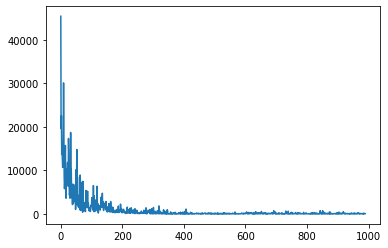

In [204]:
plt.plot(losses)

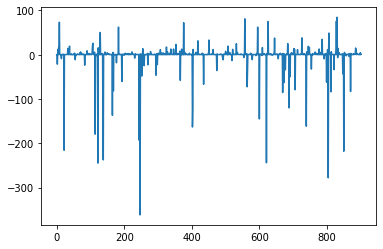

In [205]:
plt.plot(scores)


Testing state implementation. Now all we have to do is plug it in to the q learning code.